In [ ]:
pip install geopandas


In [2]:
from shapely.ops import unary_union

simplify the geometries of the London boroughs

In [3]:
import json
import geopandas as gpd
from shapely.geometry import shape, mapping

geojson_path = 'london_boroughs.geojson'
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

cleaned_features = []
for feature in geojson_data['features']:
    try:
        geom = shape(feature['geometry'])  
        cleaned_features.append({
            'geometry': geom.simplify(0.001),  
            **feature['properties']
        })
    except Exception as e:
        print(f"An error occurred while processing the feature: {e}")

london_boroughs = gpd.GeoDataFrame(
    cleaned_features,
    geometry=[feature['geometry'] for feature in cleaned_features]
)

simplified_geojson_path = 'london_boroughs_simplified.geojson'
london_boroughs.to_file(simplified_geojson_path, driver="GeoJSON")

simplified_geojson_path


/opt/anaconda3/envs/pyold/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


'london_boroughs_simplified.geojson'

Preliminary concept drawing


In [ ]:
pip install geopandas matplotlib pandas

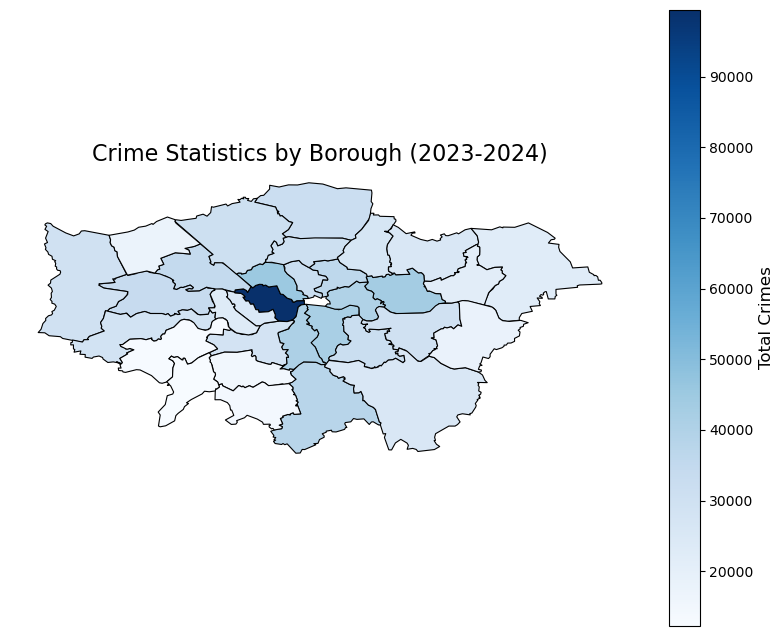

In [5]:
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt

csv_file_path = 'merged_borough_crime_geo_with_coords.csv'
data = pd.read_csv(csv_file_path)

data['geometry'] = data['geometry'].apply(lambda x: shape(json.loads(x)))

gdf = gpd.GeoDataFrame(data, geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(
    column='Total',  
    cmap='Blues',    
    linewidth=0.8,  
    ax=ax,          
    edgecolor='black'  
)


ax.set_title('Crime Statistics by Borough (2023-2024)', fontsize=16)
ax.axis('off')  
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=gdf['Total'].min(), vmax=gdf['Total'].max()))
sm._A = []  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Total Crimes', fontsize=12)

plt.show()


In [6]:

print(data['geometry'].head())

0    POLYGON ((-0.1116418 51.5153537, -0.1228498 51...
1    POLYGON ((-0.1423678 51.5693048, -0.1503078 51...
2    POLYGON ((0.0684322 51.5445468, 0.0678632 51.5...
3    POLYGON ((-0.0802148 51.5068827, -0.1091118 51...
4    POLYGON ((-0.088969669308567 51.43092448794319...
Name: geometry, dtype: object


In [7]:
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, mapping
import json
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import branca

csv_file_path = 'reordered_borough_crime_with_major_type.csv'
data = pd.read_csv(csv_file_path)

data['geometry'] = data['geometry'].apply(lambda x: shape(json.loads(x)))

gdf = gpd.GeoDataFrame(data, geometry='geometry')

min_crimes, max_crimes = gdf['Total'].min(), gdf['Total'].max()
norm = Normalize(vmin=min_crimes, vmax=max_crimes)  
colormap = cm.ScalarMappable(norm=norm, cmap='Reds') 

branca_colormap = branca.colormap.LinearColormap(
    colors=[colormap.get_cmap()(i / 256) for i in range(256)],  
    vmin=min_crimes,
    vmax=max_crimes,
    caption='Total Crimes' 
)

branca_colormap = branca_colormap.to_step(n=10)  
branca_colormap.caption = 'Total Crimes' 

m = folium.Map(location=[51.5074, -0.1278], zoom_start=10)  

for _, row in gdf.iterrows():

    geo_json = mapping(row['geometry'])
    
    crime_count = row['Total']
    rgba_color = colormap.to_rgba(crime_count, bytes=True)
    hex_color = f'#{rgba_color[0]:02x}{rgba_color[1]:02x}{rgba_color[2]:02x}'  
    
    folium.GeoJson(
        geo_json,
        style_function=lambda feature, color=hex_color: {
            'fillColor': color, 
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.7,
        },
        tooltip=folium.Tooltip(
            f"<b>Borough:</b> {row['BoroughName']}<br>"
            f"<b>Total Crimes:</b> {row['Total']}<br>"
            f"<b>Major Crime Type:</b> {row['MajorText']}"
        )
    ).add_to(m)


branca_colormap.add_to(m)  

map_path = './london_crime_interactive_map_with_integer_colormap.html'
m.save(map_path)

print(f"Interactive map saved to: {map_path}")




Interactive map saved to: ./london_crime_interactive_map_with_integer_colormap.html
